In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind, shapiro, levene, mannwhitneyu
from metrics import plot_roc_auc_curves, plot_precision_recall_curves

In [2]:
df = pd.read_csv(r"C:\Users\ruben\OneDrive\Desktop\Loan approvval\credit_risk_dataset.csv")
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [3]:
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [4]:
categorical_columns = df.select_dtypes(include="object").columns

for col in categorical_columns:
    contingency = pd.crosstab(df[col], df["loan_status"])
    woe = np.log((contingency[0] / contingency[0].sum()) / (contingency[1] / contingency[1].sum()))
    df[col + '_woe'] = df[col].map(woe)

df["cb_person_default_on_file"] = df["cb_person_default_on_file"].map({"Y": 1, "N": 0})
df.drop(categorical_columns, axis=1, inplace=True)

In [5]:
df["person_emp_length"] = df["person_emp_length"].fillna(df["person_emp_length"].median())
df["loan_int_rate"] = df["loan_int_rate"].fillna(df["loan_int_rate"].median())

In [6]:
df.loc[df["person_emp_length"] > 60, "person_emp_length"] = df["person_emp_length"].median()

In [73]:
sns.catplot(x="loan_intent", y="loan_int_rate", data=df)

ValueError: Could not interpret value `loan_intent` for `x`. An entry with this name does not appear in `data`.

<Axes: xlabel='loan_status', ylabel='loan_grade'>

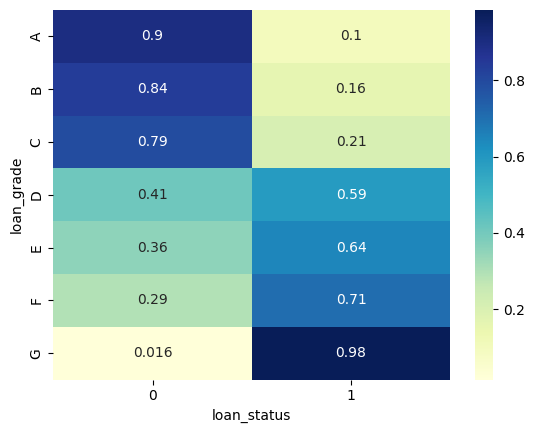

In [9]:
sns.heatmap(crosstab, annot=True, cmap="YlGnBu")

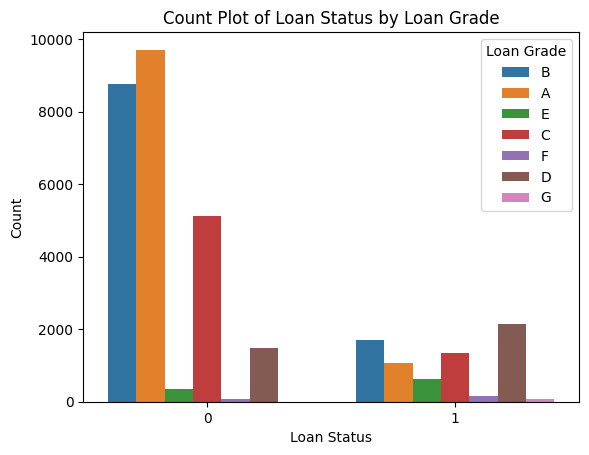

In [56]:
sns.countplot(data=df, x="loan_status", hue="loan_grade")
plt.title("Count Plot of Loan Status by Loan Grade")
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.legend(title="Loan Grade")
plt.show()

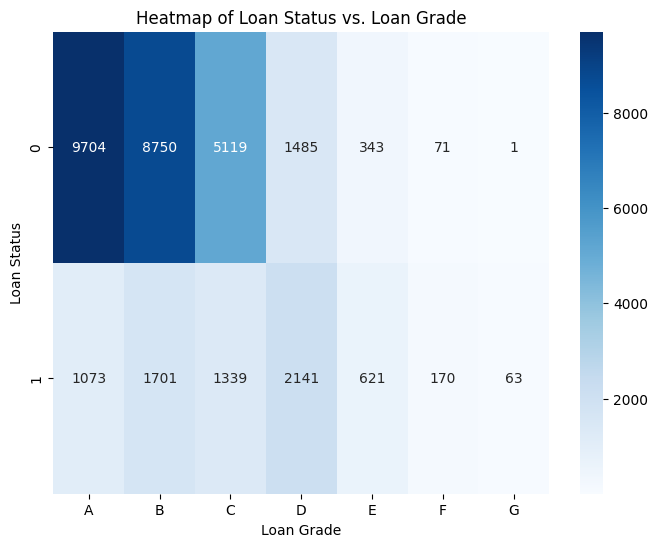

In [59]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Create a crosstab of counts
crosstab = pd.crosstab(df["loan_status"], df["loan_grade"])

# Plot a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(crosstab, annot=True, fmt="d", cmap="Blues")
plt.title("Heatmap of Loan Status vs. Loan Grade")
plt.xlabel("Loan Grade")
plt.ylabel("Loan Status")
plt.show()

<Axes: xlabel='person_emp_length', ylabel='loan_int_rate'>

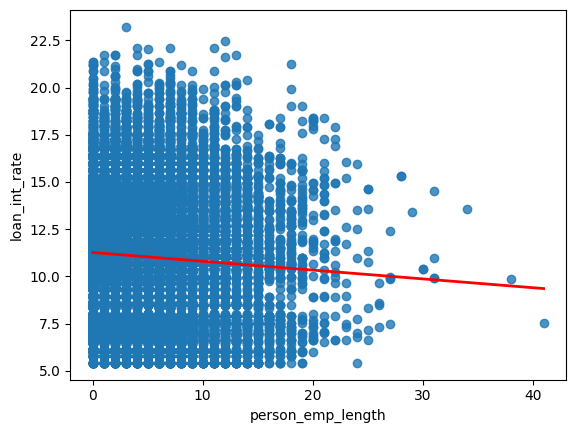

In [10]:
sns.regplot(x="person_emp_length", y="loan_int_rate", data=df, line_kws={'color': 'red', 'linewidth': 2}, ci=None)

<Axes: xlabel='loan_int_rate', ylabel='Count'>

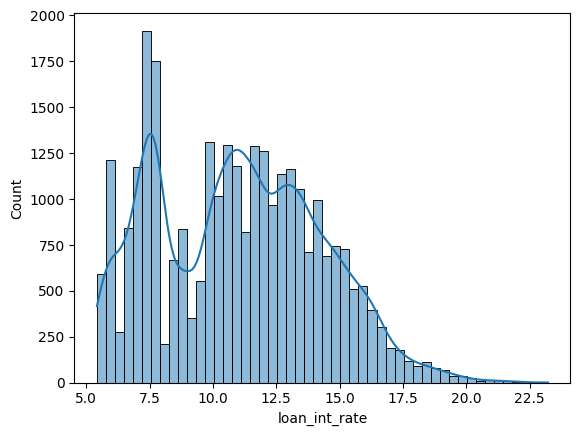

In [17]:
df[df["loan_int_rate"].isna()]
sns.histplot(df["loan_int_rate"], kde=True, bins=50)

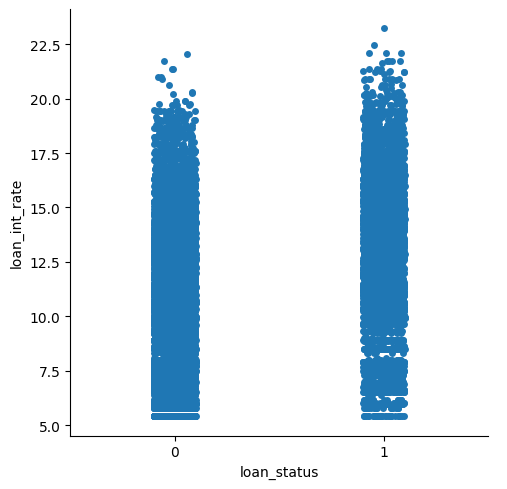

In [18]:
sns.catplot(data=df, x="loan_status", y="loan_int_rate")

In [25]:
df.groupby("loan_status")["loan_int_rate"].agg(['min', 'mean', 'median', 'max'])

,min,mean,median,max
loan_status,,,,
0,5.42,10.435999,10.59,22.06
1,5.42,13.060207,13.49,23.22


In [7]:
import pandas as pd
from scipy.stats import ttest_ind, levene, mannwhitneyu
import matplotlib.pyplot as plt
import scipy.stats as stats

# Drop NaN values
group_0 = df[df["loan_status"] == 0]["loan_int_rate"].dropna()
group_1 = df[df["loan_status"] == 1]["loan_int_rate"].dropna()

# Check equal variance
stat, p_value_var = levene(group_0, group_1)
print(f"Levene's test: statistic = {stat:.4f}, p-value = {p_value_var:.4f}")

# Perform t-test or Mann-Whitney U test
if p_value_var > 0.05:  # Equal variances
    t_stat, p_value = ttest_ind(group_0, group_1, equal_var=True)
else:  # Unequal variances (Welch's t-test)
    t_stat, p_value = ttest_ind(group_0, group_1, equal_var=False)

print(f"T-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

# Non-parametric test if necessary
if p_value < 0.05:  # If t-test shows significance
    u_stat, p_value_mwu = mannwhitneyu(group_0, group_1)
    print(f"Mann-Whitney U test: U-statistic = {u_stat:.4f}, p-value = {p_value_mwu:.4f}")

Levene's test: statistic = 253.7127, p-value = 0.0000
T-test: t-statistic = -56.9053, p-value = 0.0000
Mann-Whitney U test: U-statistic = 52845343.5000, p-value = 0.0000


In [8]:
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
df['fold'] = -1

for fold, (train_idx, val_idx) in enumerate(skf.split(X=df, y=df['loan_status'])):
    df.loc[val_idx, 'fold'] = fold

roc_auc_list = []
pr_auc_list = []
fpr_list = []
tpr_list = []
precision_list = []
recall_list = []

for fold in range(df["fold"].nunique()):
    train = df[df["fold"] != fold]
    test = df[df["fold"] == fold]

    X_train = train.drop(["loan_status", "fold"], axis=1)
    y_train = train["loan_status"]

    X_test = test.drop(["loan_status", "fold"], axis=1)
    y_test = test["loan_status"]

    xgb = XGBClassifier()
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    #df.loc[X_test.index, "xgb_pred"] = y_pred

    y_pred_proba = xgb.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)

    roc_auc_list.append(roc_auc)
    pr_auc_list.append(pr_auc)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    precision_list.append(precision)
    recall_list.append(recall)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print(f"Fold {fold}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")

Fold 0: Accuracy = 0.9351, Precision = 0.9621, Recall = 0.7314
Fold 1: Accuracy = 0.9369, Precision = 0.9650, Recall = 0.7377
Fold 2: Accuracy = 0.9366, Precision = 0.9599, Recall = 0.7405
Fold 3: Accuracy = 0.9317, Precision = 0.9535, Recall = 0.7220
Fold 4: Accuracy = 0.9415, Precision = 0.9668, Recall = 0.7579


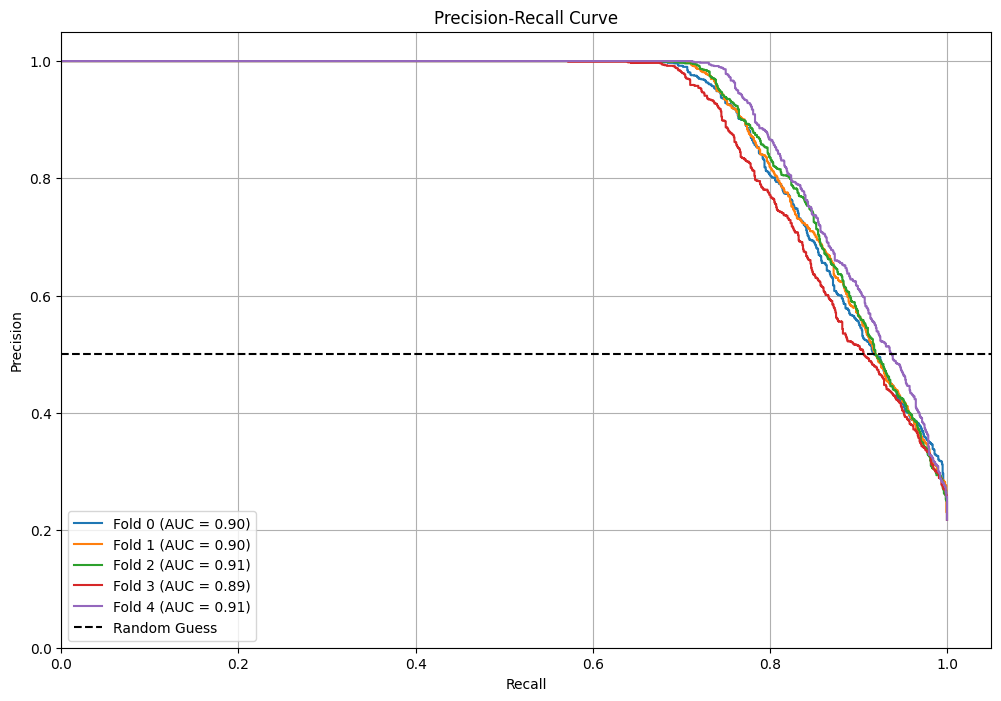

In [10]:
plot_precision_recall_curves(recall_list, precision_list, pr_auc_list)

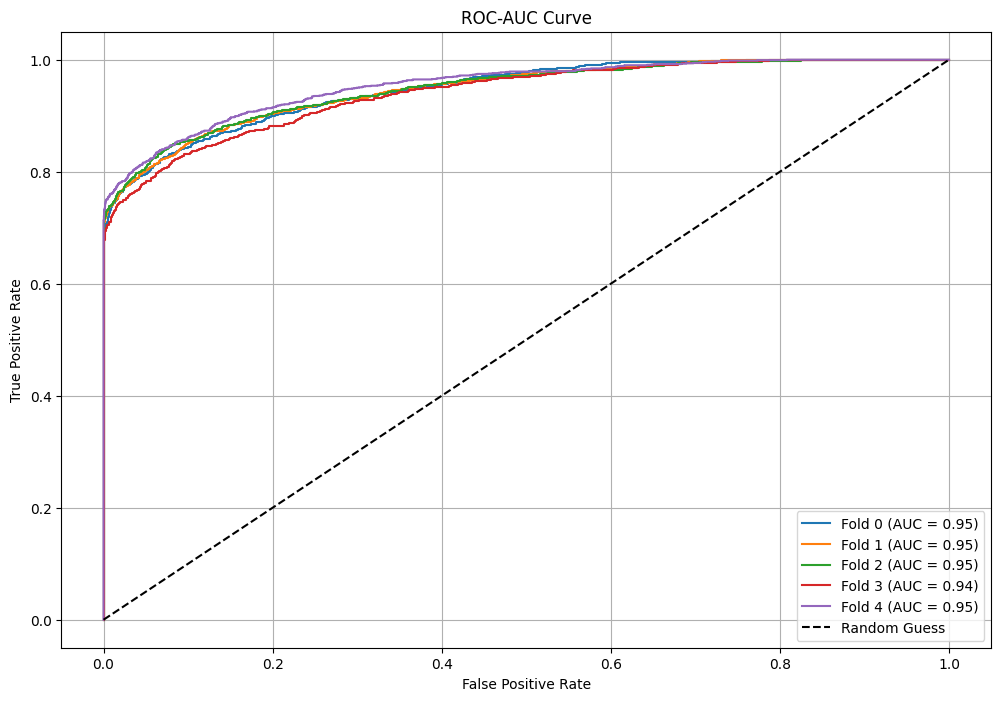

In [11]:
plot_roc_auc_curves(fpr_list, tpr_list, roc_auc_list)

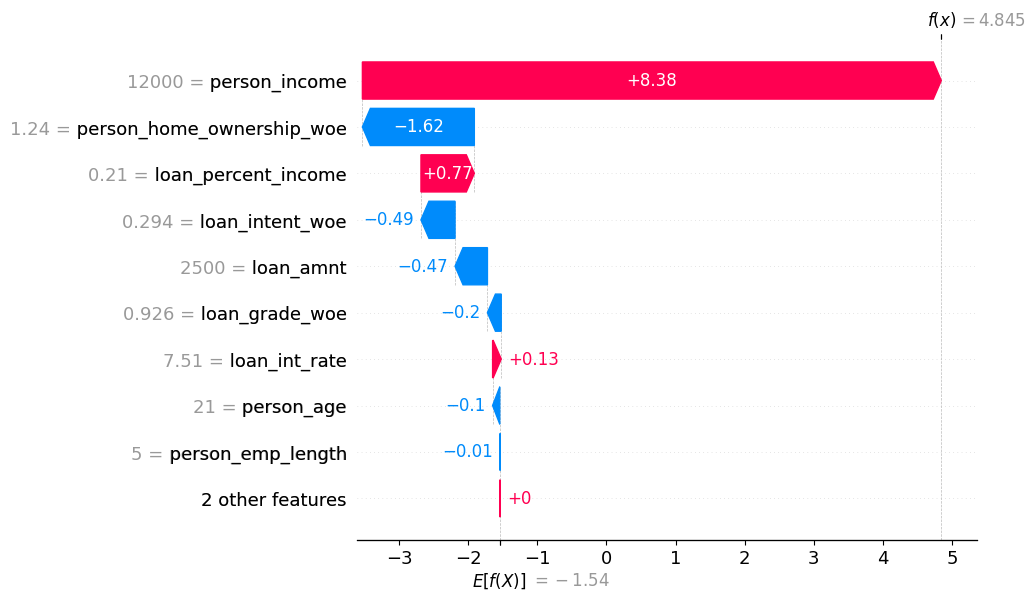

In [197]:
import shap

explainer = shap.TreeExplainer(xgb)
shap_values = explainer(X_test)

instance_idx = 7

shap.plots.waterfall(shap_values[instance_idx])

In [198]:
df.loc[X_test.index[instance_idx], :].to_frame()

,35
person_age,21.00
person_income,12000.00
person_emp_length,5.00
loan_amnt,2500.00
loan_int_rate,7.51
loan_status,1.00
loan_percent_income,0.21
cb_person_cred_hist_length,4.00
person_home_ownership_woe,1.24
loan_intent_woe,0.29


In [193]:
probability = 1 / (1 + np.exp(-2.148))
print(probability)

0.8954817364932597


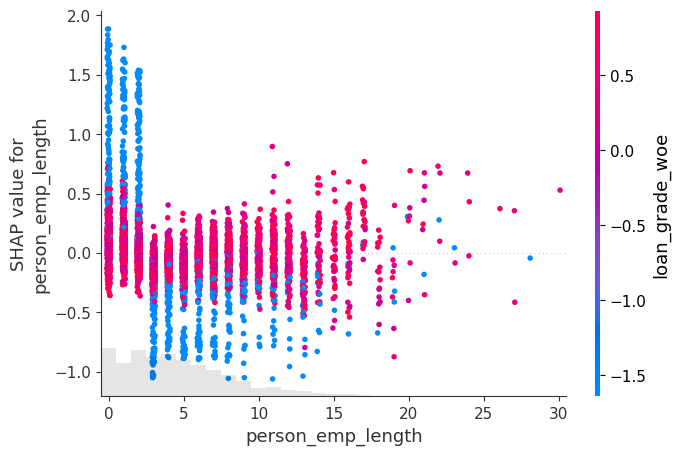

In [195]:
shap.plots.scatter(shap_values[:, "person_emp_length"], color=shap_values)